In [2]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

import flaml
from flaml import AutoML

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'

sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_CERRA.yaml' #sys.argv[1]
train_years = int(1) #int(sys.argv[2])
Ens = 0 #int(sys.argv[3]) #ensemble number

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    configure = yaml.safe_load(yaml_file)
input_file = configure['input_file']
input_times_freq = configure['input_times_freq']
Coeff_file = configure['Coeff_file']
profiles_file = None if configure['profiles_file'] == '' else configure['profiles_file']
input_variables = configure['input_variables']
train_locations = configure['train_locations']
test_dates_range = configure['test_dates_range']
test_locations = configure['test_locations']
nEns = configure['nEns']
tabnet_param_file = configure['tabnet_param_file']
target_variables = configure['target_variables']
experiment = configure['experiment']

In [3]:
test_dates_range

['2017-03-24T00:00:00', '2018-04-11T23:00:00']

In [4]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2017-10-17T03:00:00','2017-06-06T10:00:00'],
                'Low shear/well mixed':['2017-05-10T12:00:00','2017-11-20T13:00:00'],
                'LLJ': ['2018-04-10T03:00:00','2017-03-30T02:00:00'],
                'High wind': ['2017-12-31T12:00:00','2018-01-05T04:00:00'],
                }
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

In [5]:
for run,year in enumerate(np.arange(2000,2001+1-train_years)):
    train_dates_range = [str(year)+'-01-01',str(year+train_years-1)+'-12-31']
    print(run,train_dates_range)

    # === training and validation data parameters ===#
    X_train,Y_train, X_valid,Y_valid = data_processing(input_file,Coeff_file,input_times_freq,
                                                       input_variables,target_variables,train_dates_range,train_locations,val_arg=True,
                                                       profiles_file=profiles_file,threshold=2)
    print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

0 ['2000-01-01', '2000-12-31']
training inputs shape: (6503, 24) training targets shape: (6503, 5) validation inputs shape: (1609, 24) validation targets shape: (1609, 5)


In [6]:
import pandas as pd

# Define the start and end dates
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2000-12-31')

# Calculate the number of hours between the dates
hours_between = (end_date - start_date).total_seconds() / 3600

print("Number of hours between 2000 Jan 1 and 2016 Dec 31:", hours_between)


Number of hours between 2000 Jan 1 and 2016 Dec 31: 8760.0


### Simple XGBoost multioutput

In [6]:
import xgboost as xgb

reg = xgb.XGBRegressor(
        tree_method="hist",
        n_estimators=128,
        n_jobs=16,
        max_depth=8,
        multi_strategy='multi_output_tree',
        subsample=0.6,
    )
reg.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

[0]	validation_0-rmse:3.65864
[1]	validation_0-rmse:2.60008
[2]	validation_0-rmse:1.87073
[3]	validation_0-rmse:1.37325
[4]	validation_0-rmse:1.04395
[5]	validation_0-rmse:0.84562
[6]	validation_0-rmse:0.71693
[7]	validation_0-rmse:0.64376
[8]	validation_0-rmse:0.60212
[9]	validation_0-rmse:0.57952
[10]	validation_0-rmse:0.56720
[11]	validation_0-rmse:0.56160
[12]	validation_0-rmse:0.56168
[13]	validation_0-rmse:0.55862
[14]	validation_0-rmse:0.55784
[15]	validation_0-rmse:0.55691
[16]	validation_0-rmse:0.55763
[17]	validation_0-rmse:0.55833
[18]	validation_0-rmse:0.55856
[19]	validation_0-rmse:0.55914
[20]	validation_0-rmse:0.55867
[21]	validation_0-rmse:0.55834
[22]	validation_0-rmse:0.56012
[23]	validation_0-rmse:0.56126
[24]	validation_0-rmse:0.56086
[25]	validation_0-rmse:0.56308
[26]	validation_0-rmse:0.56366
[27]	validation_0-rmse:0.56304
[28]	validation_0-rmse:0.56264
[29]	validation_0-rmse:0.56299
[30]	validation_0-rmse:0.56538
[31]	validation_0-rmse:0.56567
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=128, n_jobs=16,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 24) testing targets shape: (9216, 5)


In [8]:
Y_pred = reg.predict(X_test)
print('testing predictions shape:',Y_pred.shape)

testing predictions shape: (9216, 5)


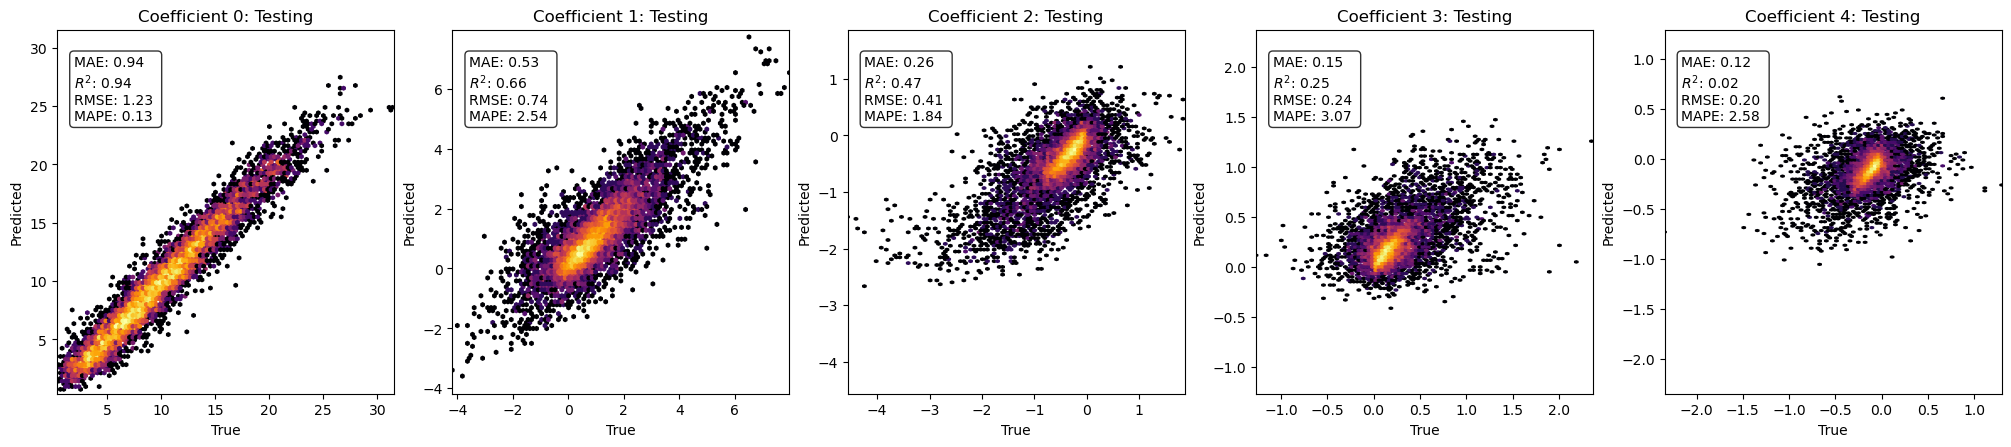

In [9]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)

for i,target_variable in enumerate(target_variables):
    hexbin_plotter(fig,gs[0,i],Y_test[:,i],Y_pred[:,i],f'Coefficient {target_variable}: Testing',text_arg=True,xlabel='True',ylabel='Predicted')

plt.savefig(f'Figures/multi_output_xgboost_CERRA_targets_coefficients_hexbin_plot.png',dpi=300)

### Trying for multiregresison

In [11]:
class MultiOutputXGBoostEstimator(flaml.automl.model.XGBoostEstimator):
    """Enable multi-output XGBoost. 
    Check https://xgboost.readthedocs.io/en/stable/tutorials/multioutput.html
    """

    def __init__(self, task="binary", **config):
        assert task == "regression", "Only regression is supported."
        config.update({
            "tree_method": "hist",
            "strategy": "multi_output_tree",
        })
        super().__init__(task=task, **config)
    
automl = AutoML(estimator_list=["xgboost_mo"])
automl.add_learner("xgboost_mo", MultiOutputXGBoostEstimator)

settings = {
    "time_budget": 3600,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "early_stop": True,
    "sample": True, #A boolean of whether to sample the training data during search
    "ensemble": False, #Whether to perform ensemble after search
    "model_history": True, #A boolean of whether to keep the best model per estimator
    "retrain_full": True, #whether to retrain the selected model on the full training data
}

automl.fit(X_train=X_train, y_train = Y_train, X_val=X_valid, y_val=Y_valid, **settings)

[flaml.automl.logger: 02-14 13:45:52] {1728} INFO - task = regression
[flaml.automl.logger: 02-14 13:45:52] {1736} INFO - Data split method: uniform
[flaml.automl.logger: 02-14 13:45:52] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 02-14 13:45:52] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 02-14 13:45:52] {1955} INFO - List of ML learners in AutoML Run: ['xgboost_mo']
[flaml.automl.logger: 02-14 13:45:52] {2258} INFO - iteration 0, current learner xgboost_mo
[flaml.automl.logger: 02-14 13:45:52] {2393} INFO - Estimated sufficient time budget=257s. Estimated necessary time budget=0s.
[flaml.automl.logger: 02-14 13:45:52] {2442} INFO -  at 0.0s,	estimator xgboost_mo's best error=3.0946,	best estimator xgboost_mo's best error=3.0946
[flaml.automl.logger: 02-14 13:45:52] {2258} INFO - iteration 1, current learner xgboost_mo
[flaml.automl.logger: 02-14 13:45:52] {2442} INFO -  at 0.1s,	estimator xgboost_mo's best error=2.1809,	best estimator xgboost_

In [12]:
# === testing data parameters ===#
X_test,Y_test = data_processing(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (9216, 24) testing targets shape: (9216, 5)


In [13]:
Y_pred = automl.predict(X_test)
print('testing predictions shape:',Y_pred.shape)

testing predictions shape: (9216, 5)


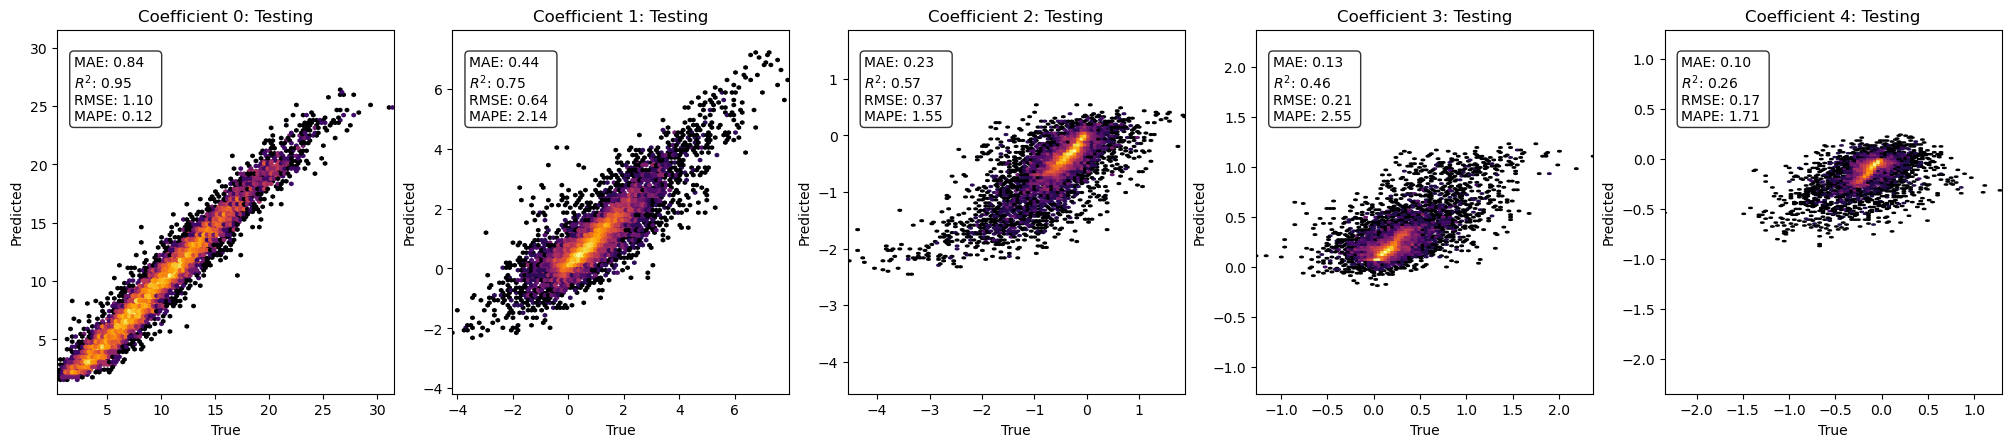

In [15]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
gs = fig.add_gridspec(2,5)

for i,target_variable in enumerate(target_variables):
    hexbin_plotter(fig,gs[0,i],Y_test[:,i],Y_pred[:,i],f'Coefficient {target_variable}: Testing',text_arg=True,xlabel='True',ylabel='Predicted')

plt.savefig(f'Figures/multi_output_FLAML_xgboost_CERRA_targets_coefficients_hexbin_plot.png',dpi=300)